In [1]:
import scanpy as sc
import senepy as sp
import seaborn as sns
import numpy as np
import pandas as pd

import random

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

from tqdm import tqdm

In [2]:
adata = sc.read_h5ad('../../data/tms/tms-scVI-raw-data_BDATA.h5ad')

In [3]:
sc.pp.normalize_total(adata)

In [4]:
sc.pp.log1p(adata)

In [5]:
adata = adata[adata.obs.tissue_cell == 'Tongue_keratinocyte'].copy()

In [6]:
adata

AnnData object with n_obs × n_vars = 12335 × 20116
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tissue2', 'tissue_cell', 'cell_type_2'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'log1p'
    obsm: 'X_scvi'

In [7]:
adata.X.max()

8.91142

In [8]:
hubs = sp.load_hubs(species = 'Mouse')

In [9]:
hubs.metadata[hubs.metadata.tissue == 'Tongue']

,tissue,cell,hub_num,size,n_sen,hyp
65,Tongue,basal cell,0,66,7,2.360556e-06
66,Tongue,basal cell,1,55,2,9.022929e-02
67,Tongue,keratinocyte,0,133,14,2.068164e-11
68,Tongue,keratinocyte,1,86,5,1.160686e-03


In [10]:
hub = hubs.hubs[('Tongue', 'keratinocyte', 0)]

In [11]:
def label_points_wstuff(x):
    sc, sen = x
    if sc == 'Sig' and sen == 'not':
        return 'scrds'
    if sc == 'not' and sen == 'Sig':
        return 'senepy'
    if sc == 'Sig' and sen == 'Sig':
        return 'both'

    return 'none'

In [12]:
adata.obs['scdrs'] = sp.score_hub_scdrs(adata, hub)
adata.obs['scrds_p'] = adata.uns['scdrs_stats'].mc_pval
adata.obs['scrds_sig'] = adata.obs['scrds_p'].map(lambda x: 'Sig' if x < 0.05 else 'not')

Please cite scDRS if you use this function in your work: doi.org/10.1038/s41588-022-01167-z
To quiet this message pass citation = True


Computing control scores: 100%|█████████████| 1000/1000 [00:58<00:00, 17.24it/s]


In [13]:
#binarize = False, importance = True


adata.obs['senepy2'] = sp.score_hub(adata, hub, binarize = False, importance = True)
mu = adata.obs['senepy2'].mean()
sd = adata.obs['senepy2'].std()
thresh = mu + 2*sd
adata.obs['senepy_sig'] = adata.obs['senepy2'].map(lambda x: 'Sig' if x >= thresh else 'not')

adata.obs['scdrs_v_senpy'] = adata.obs[['scrds_sig' , 'senepy_sig']].apply(label_points_wstuff, axis = 1)

In [14]:
r, p = stats.pearsonr(adata.obs.senepy2, adata.obs.scdrs)

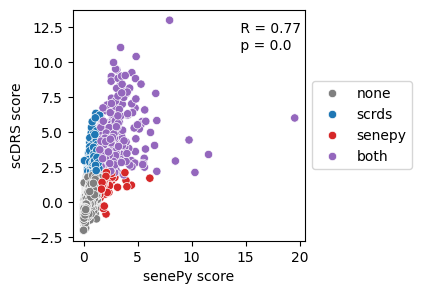

In [15]:
plt.figure(figsize = (3,3))

sns.scatterplot(data = adata.obs, x = 'senepy2', y = 'scdrs', hue='scdrs_v_senpy',
                palette = ['tab:grey', 'tab:blue', 'tab:red', 'tab:purple'], 
                hue_order = ['none', 'scrds', 'senepy', 'both'])


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.text(0.7, 0.95, f" R = {round(r, 2)}",
         transform=plt.gca().transAxes, ha='left', va='top')
plt.text(0.7, 0.875, f" p = {round(p, 2)}",
         transform=plt.gca().transAxes, ha='left', va='top')


plt.xlabel('senePy score')
plt.ylabel('scDRS score')



# plt.savefig('/home/jrlab/storage/senepy/paper_1/PAPER_CODE/figures/scdrs_v_senepy_scatter.png',
#             dpi = 600, transparent = True, bbox_inches = 'tight')

# plt.savefig('/home/jrlab/storage/senepy/paper_1/PAPER_CODE/figures/scdrs_v_senepy_scatter.svg',
# transparent = True, bbox_inches = 'tight')


plt.show()

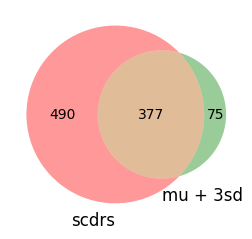

In [16]:
set1 = set(adata.obs[adata.obs.scrds_sig == 'Sig'].index)
set2 = set(adata.obs[adata.obs.senepy_sig == 'Sig'].index)

# Create the Venn diagram
plt.figure(figsize=(3, 3))
venn2([set1, set2], ('scdrs', 'mu + 3sd'))

plt.show()

In [17]:
points = np.linspace(0, 4, 21)

In [18]:
points

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. ])

In [19]:
#testing at multiple std thresholds



set1 = set(adata.obs[adata.obs.scrds_sig == 'Sig'].index)

res = []
for x in tqdm(points):
    for method in ['binary', 'norm', 'random']:
        if method == 'binary':
            adata.obs['senepy2'] = sp.score_hub(adata, hub, binarize = True, importance = True)
        else:
            adata.obs['senepy2'] = sp.score_hub(adata, hub, binarize = False, importance = True)
  
            
        mu = adata.obs['senepy2'].mean()
        sd = adata.obs['senepy2'].std()
        thresh = mu + x*sd
        adata.obs['senepy_sig'] = adata.obs['senepy2'].map(lambda x: 'Sig' if x >= thresh else 'not')
    

        set2 = set(adata.obs[adata.obs.senepy_sig == 'Sig'].index)
        
        if method == 'random':
            set2 = set(random.choices(adata.obs_names, k = len(set2)))

    
        er = (len(set1.intersection(set2))/len(set2))/(len(set1)/len(adata))
        p = stats.hypergeom.sf(len(set1.intersection(set2)), len(adata), len(set1), len(set2))
        j = len(set1.intersection(set2))/len(set1.union(set2))
        #o = len(set1.intersection(set2))/min(len(set1), len(set2))
        o = len(set1.intersection(set2))/len(set2)

    
        res.append([x, len(set2), len(set1.intersection(set2)), j, o,  er, p, method])

100%|███████████████████████████████████████████| 21/21 [01:46<00:00,  5.09s/it]


In [20]:
res = pd.DataFrame(res, columns = ['sd', 'n', 'Int', 'jac' ,'overlap', 'er', 'p', 'method'])

In [25]:
res[res.method != 'random'].sort_values('p').tail()

,sd,n,Int,jac,overlap,er,p,method
51,3.4,169,131,0.144751,0.775148,11.028200,9.476077e-121,binary
48,3.2,169,131,0.144751,0.775148,11.028200,9.476077e-121,binary
24,1.6,205,143,0.153929,0.697561,9.924354,1.655484e-120,binary
21,1.4,229,149,0.157339,0.650655,9.257012,1.671251e-118,binary
18,1.2,248,153,0.159044,0.616935,8.777277,1.931024e-116,binary


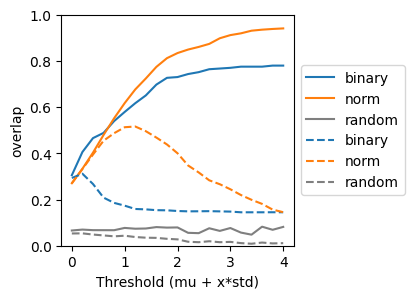

In [373]:
plt.figure(figsize = (3,3))
sns.lineplot(data = res, x = 'sd', y = 'overlap', hue = 'method',
             palette=['tab:blue', 'tab:orange', 'tab:grey'])
sns.lineplot(data = res, x = 'sd', y = 'jac', hue = 'method',
             linestyle="--", palette=['tab:blue', 'tab:orange', 'tab:grey'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Threshold (mu + x*std)')

plt.ylim(top = 1, bottom = 0)


plt.savefig('/home/jrlab/storage/senepy/paper_1/PAPER_CODE/figures/scdrs_v_senepy_overlap.png',
            dpi = 600, transparent = True, bbox_inches = 'tight')

plt.savefig('/home/jrlab/storage/senepy/paper_1/PAPER_CODE/figures/scdrs_v_senepy_overlap.svg',
transparent = True, bbox_inches = 'tight')




plt.show()

In [260]:
res['nlogp'] = -np.log10(res.p.replace(0, np.finfo(np.float64).tiny))

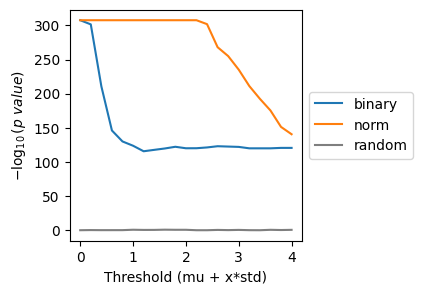

In [283]:
plt.figure(figsize = (3,3))



ax = sns.lineplot(data = res, x = 'sd', y = 'nlogp', hue = 'method', palette=['tab:blue', 'tab:orange', 'tab:grey'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel(r'$-\log_{10}(p\ value)$')
plt.xlabel('Threshold (mu + x*std)')

plt.savefig('/home/jrlab/storage/senepy/paper_1/PAPER_CODE/figures/scdrs_v_senepy.png',
            dpi = 600, transparent = True, bbox_inches = 'tight')

plt.savefig('/home/jrlab/storage/senepy/paper_1/PAPER_CODE/figures/scdrs_v_senepy.svg',
transparent = True, bbox_inches = 'tight')

plt.show()

In [321]:
#binarize and amplify = True


adata.obs['senepy2'] = sp.score_hub(adata, hub, binarize = True, importance = True)
mu = adata.obs['senepy2'].mean()
sd = adata.obs['senepy2'].std()
thresh = mu + 2*sd
adata.obs['senepy_sig'] = adata.obs['senepy2'].map(lambda x: 'Sig' if x >= thresh else 'not')

adata.obs['scdrs_v_senpy'] = adata.obs[['scrds_sig' , 'senepy_sig']].apply(label_points_wstuff, axis = 1)

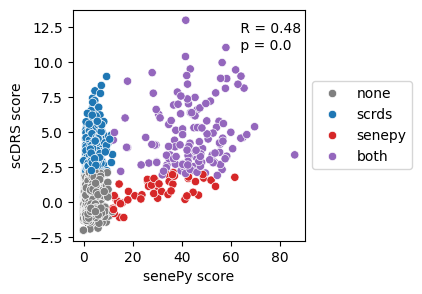

In [323]:

r, p = stats.pearsonr(adata.obs.senepy2, adata.obs.scdrs)

plt.figure(figsize = (3,3))

sns.scatterplot(data = adata.obs, x = 'senepy2', y = 'scdrs', hue='scdrs_v_senpy',
                palette = ['tab:grey', 'tab:blue', 'tab:red', 'tab:purple'], 
                hue_order = ['none', 'scrds', 'senepy', 'both'])


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.text(0.7, 0.95, f" R = {round(r, 2)}",
         transform=plt.gca().transAxes, ha='left', va='top')
plt.text(0.7, 0.875, f" p = {round(p, 2)}",
         transform=plt.gca().transAxes, ha='left', va='top')


plt.xlabel('senePy score')
plt.ylabel('scDRS score')



plt.savefig('/home/jrlab/storage/senepy/paper_1/PAPER_CODE/figures/scdrs_v_senepy_scatter_binary.png',
            dpi = 600, transparent = True, bbox_inches = 'tight')

plt.savefig('/home/jrlab/storage/senepy/paper_1/PAPER_CODE/figures/scdrs_v_senepy_scatter_binary.svg',
transparent = True, bbox_inches = 'tight')


plt.show()

In [324]:
set_binary = set(adata.obs[adata.obs.senepy_sig == 'Sig'].index)

In [325]:
#run code up higher to get non-binary set again
adata.obs['senepy2'] = sp.score_hub(adata, hub, binarize = False, importance = True)
mu = adata.obs['senepy2'].mean()
sd = adata.obs['senepy2'].std()
thresh = mu + 2*sd
adata.obs['senepy_sig'] = adata.obs['senepy2'].map(lambda x: 'Sig' if x >= thresh else 'not')

adata.obs['scdrs_v_senpy'] = adata.obs[['scrds_sig' , 'senepy_sig']].apply(label_points_wstuff, axis = 1)

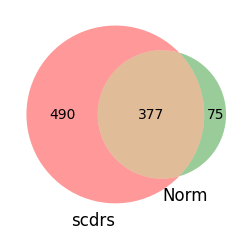

In [336]:
set1 = set(adata.obs[adata.obs.scrds_sig == 'Sig'].index)
set2 = set(adata.obs[adata.obs.senepy_sig == 'Sig'].index)

# Create the Venn diagram
plt.figure(figsize=(3, 3))
venn2([set1, set2], ('scdrs', 'Norm'))



plt.show()

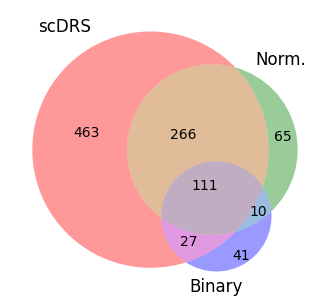

In [337]:
set1 = set(adata.obs[adata.obs.scrds_sig == 'Sig'].index)
set2 = set(adata.obs[adata.obs.senepy_sig == 'Sig'].index)

# Create the Venn diagram for three sets
plt.figure(figsize=(4, 4))
venn3([set1, set2, set_binary], ('scDRS', 'Norm.', 'Binary'))


plt.savefig('/home/jrlab/storage/senepy/paper_1/PAPER_CODE/figures/scdrs_v_senepy_venn.png',
            dpi = 600, transparent = True, bbox_inches = 'tight')

plt.savefig('/home/jrlab/storage/senepy/paper_1/PAPER_CODE/figures/scdrs_v_senepy_venn.svg',
transparent = True, bbox_inches = 'tight')


plt.show()


In [ ]:
#final thing is to show distributions of senepy scores and how it is bimodal? but does this conflight when
#at other points in the paper the distributions arent bimodal?

In [ ]:
#final thing is to show the difference at multiple ages

In [ ]:
cells_p_age = 

In [356]:
cells_p_age = adata.obs.groupby('age', observed = True).size().reset_index(name = 'total_cells')

In [357]:
cells_p_age

,age,total_cells
0,1m,2711
1,3m,3884
2,18m,2118
3,24m,3622


In [386]:
scdrs = adata.obs.groupby(['age', 'scrds_sig'], observed = True).size().reset_index(name = 'n_cells')
scdrs = scdrs.merge(cells_p_age, on='age')

scdrs['method'] = 'scDRS'
scdrs = scdrs.rename(columns = {'scrds_sig': 'senescent'})

scdrs['prop'] = scdrs.n_cells / scdrs.total_cells

In [395]:
sene = adata.obs.groupby(['age', 'senepy_sig'], observed = True).size().reset_index(name = 'n_cells')
sene = sene.merge(cells_p_age, on='age')

sene['method'] = 'senePy'
sene = sene.rename(columns = {'senepy_sig': 'senescent'})

sene['prop'] = sene.n_cells / sene.total_cells

In [408]:
adata.obs['senepy2'] = sp.score_hub(adata, hub, binarize = True, importance = True)
mu = adata.obs['senepy2'].mean()
sd = adata.obs['senepy2'].std()
thresh = mu + 2*sd
adata.obs['senepy_sig'] = adata.obs['senepy2'].map(lambda x: 'Sig' if x >= thresh else 'not')


binary = adata.obs.groupby(['age', 'senepy_sig'], observed = False).size().reset_index(name = 'n_cells')
binary = binary.merge(cells_p_age, on='age')

binary['method'] = 'senePy_binary'
binary = binary.rename(columns = {'senepy_sig': 'senescent'})

binary['prop'] = binary.n_cells / binary.total_cells

In [409]:
df = pd.concat((scdrs, sene, binary))

In [410]:
df

,age,senescent,n_cells,total_cells,method,prop
0,1m,Sig,172,2711,scDRS,0.063445
1,1m,not,2539,2711,scDRS,0.936555
2,3m,Sig,92,3884,scDRS,0.023687
3,3m,not,3792,3884,scDRS,0.976313
4,18m,Sig,85,2118,scDRS,0.040132
5,18m,not,2033,2118,scDRS,0.959868
6,24m,Sig,518,3622,scDRS,0.143015
7,24m,not,3104,3622,scDRS,0.856985
0,1m,Sig,65,2711,senePy,0.023976
1,1m,not,2646,2711,senePy,0.976024


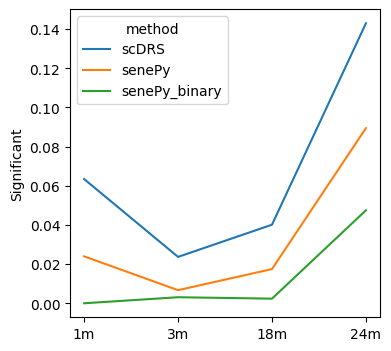

In [418]:
plt.figure(figsize = (4,4))

ax = sns.lineplot(data = df[df.senescent == 'Sig'], x = 'age', y = 'prop', hue = 'method')

plt.xlabel('')
plt.ylabel('Significant')


plt.savefig('/home/jrlab/storage/senepy/paper_1/PAPER_CODE/figures/scdrs_v_senepy_by_age.png',
            dpi = 600, transparent = True, bbox_inches = 'tight')

plt.savefig('/home/jrlab/storage/senepy/paper_1/PAPER_CODE/figures/scdrs_v_senepy_by_age.svg',
transparent = True, bbox_inches = 'tight')

plt.show()